# [1주차] 기본과제 - MNIST를 분류 모델로 학습하기

구현 목표 : MNIST 데이터로 손글씨 이미지가 어떤 숫자를 의미하는지 분류하는 모델을 구현한다.

필요한 라이브러리를 import 한다.
GPU를 사용하기 위한 설정을 한다.

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# mac에 GPU를 사용하기 위한 설정
device = torch.device("mps")

trainset과 testset 준비한다.
PyTorch를 사용하기 위해 다차원 배열인 Tensor 형태로 변환한다.

In [13]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


trainset이 잘 만들어졌는지 확인하기 위해 전체 transet data의 개수와 첫 번째 data를 출력한다.

60000
torch.Size([1, 28, 28]) 5


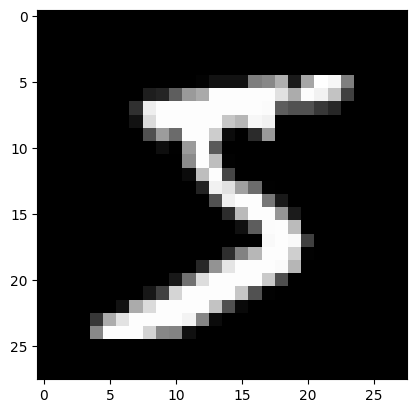

In [14]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

SGD를 위해 dataset을 여러 개의 batch로 나눈다.
여러 개의 batch로 나누면 데이터가 많아도 메모리가 부족하지 않게 gradient descent를 수행할 수 있다.
SGD는 랜덤으로 batch를 구성해야 잘 동작하기 때문에 trainloader에 shuffle=True로 설정한다.

In [15]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)


첫 번째 batch를 출력하면 다음과 같다.

In [16]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


dataloader에 대한 model의 정확도를 측정하는 코드를 추가한다.

In [17]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

(n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현한다.
이미지는 (n, 1, 28, 28) shape이기 때문에 (n, 1 * 28 * 28) shape으로 변환해서 선형 함수에 입력으로 사용할 수 있게 torch.flatten을 사용한다.  

In [18]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # 0~9까지 각 클래스에 대한 확률을 출력하기 위해 dimension을 10으로 설정
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

다음은 gradient descent를 수행해줄 optimizer를 구현한다.

In [19]:
from torch.optim import SGD

lr = 0.001
model = model.to('mps')

optimizer = SGD(model.parameters(), lr=lr)

model을 학습한다.
epoch마다 모델의 정확성을 계산해서 배열에 저장한다.

In [20]:
# 각 클래스에 대한 확률 분포를 예측하는 것으로, 분류 문제에 더 적합하다.
criterion = nn.CrossEntropyLoss()
n_epochs = 100

train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  train_acc_list.append(accuracy(model, trainloader))
  test_acc_list.append(accuracy(model, testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 540.9027667045593
Epoch   1 | Loss: 539.1684927940369
Epoch   2 | Loss: 537.4508407115936
Epoch   3 | Loss: 535.6614942550659
Epoch   4 | Loss: 533.7650535106659
Epoch   5 | Loss: 531.7629191875458
Epoch   6 | Loss: 529.6387317180634
Epoch   7 | Loss: 527.3312768936157
Epoch   8 | Loss: 524.8381750583649
Epoch   9 | Loss: 522.1042459011078
Epoch  10 | Loss: 519.0933263301849
Epoch  11 | Loss: 515.7375230789185
Epoch  12 | Loss: 512.0303122997284
Epoch  13 | Loss: 507.9269063472748
Epoch  14 | Loss: 503.393034696579
Epoch  15 | Loss: 498.42302680015564
Epoch  16 | Loss: 492.96789264678955
Epoch  17 | Loss: 486.9775035381317
Epoch  18 | Loss: 480.648730635643
Epoch  19 | Loss: 473.8630974292755
Epoch  20 | Loss: 466.75735223293304
Epoch  21 | Loss: 459.36581671237946
Epoch  22 | Loss: 451.9242626428604
Epoch  23 | Loss: 444.4339588880539
Epoch  24 | Loss: 437.02648973464966
Epoch  25 | Loss: 429.86308681964874
Epoch  26 | Loss: 422.9600330591202
Epoch  27 | Loss: 416.35

첫 번째 data에 대한 예측 결과는 다음과 같다.

In [21]:
idx = 1

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('mps')

print(model(x))
print(trainset[idx][1])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0',
       grad_fn=<ReluBackward0>)
0


모델을 학습하면서 저장한 정확도를 plot으로 출력한다.

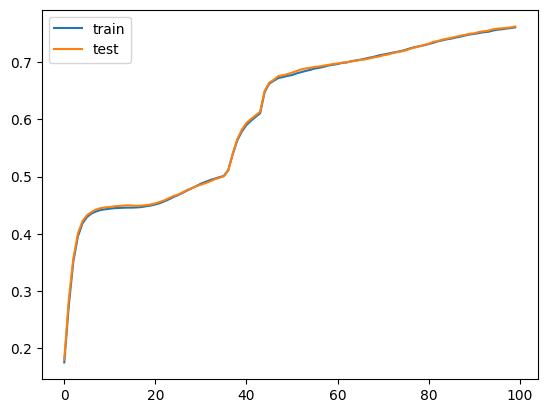

In [22]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_acc_list, test_acc_list)